In [11]:
%matplotlib inline
import matplotlib, qiskit
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, IBMQ, transpile, schedule, assemble
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeAlmaden, FakeMelbourne
# load account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# simulators:
f_alma = FakeAlmaden() # simulator f_alma for pulse schedules
f_mel = FakeMelbourne() # simulator f_mel for simulator backend mel

ibmqfactory.load_account:WARNING:2021-05-14 13:09:01,498: Credentials are already in use. The existing account in the session will be replaced.


# Tunable Scrambling Circuit

Reproduce Us(α) Ud(α) Teleportation Circuit designed to probe the OTOC and teleportation fidelity as a function of the scrambling parameter α with α = 0 representing no scrambling and α = 1 representing full scrambling.

Reference: Verified Quantum Information Scrambling https://arxiv.org/abs/1806.02807

![paper](.\\pics\\Telpo1_Tunable_Scrambling_Circ.jpg)

![experiment](.\\pics\\Telpo2_Tunable_Scrambling_Circ.jpg)

Tunable Circ:

![tunable](.\\pics\\Telpo3_Tunable_Scrambling_Circ.jpg)

## General Functions:

In [12]:
# funcs for bell pair entanglement and measurement

def entangle_bell_pairs(circ, bell_pairs):
    # Define many-body-system bell pairs
    for pair in bell_pairs:
        circ.h(pair[0])
        circ.cx(pair[0],pair[1])

def disentangle_bell_pair(circ, pair):
    circ.cx(pair[0], pair[1])
    circ.h(pair[0])

In [13]:
# func to return thet for Z rotation from Unitary parameter alpha

def get_theta_from_alpha(alpha):
    return (alpha*pi)/2

In [14]:
# find initial bell pairs for n qubit circ

def get_bell_pairs(circ):

    n = len(circ.qubits)
    # make pairings:
    if n%2 != 0:
        initalsys = [x for x in range(n)][1:-1] # put first and last qubits aside for initial entanglement of the system
        pairs = [[item,initalsys[int(len(initalsys)/2):][number]]
                         for (number,item) in enumerate(reversed(initalsys[:int(len(initalsys)/2)]))]
    else:
        print("Find out how to deal with even number circ, Hannah!")
    # append pair bob and q before bob:   
    pairs.append([n-2, n-1]) 
    
    return pairs

In [15]:
# finc to get structure of scrambling U and U* for n qubit circ

def get_unitary_pairs(circ):
    
    if n%2 != 0:
        upper_qs = [x for x in range(n-1)][:int(n/2)]
        lower_qs = [x for x in range(n-1)][int(n/2):]
    else:
        print("Find out how to deal with even number circ, Hannah!")
    
    upper_pairs = sorted([(upper_qs[i],upper_qs[i+1]) 
                   for i in range(len(upper_qs)-1)] + [(upper_qs[i],upper_qs[i+2]) 
                                                       for i in range(len(upper_qs)-2)])

    lower_pairs = sorted([(lower_qs[i],lower_qs[i+1]) 
                   for i in range(len(lower_qs)-1)] + [(lower_qs[i],lower_qs[i+2]) 
                                                       for i in range(len(lower_qs)-2)])
    
    lower_pairs = [x for x in reversed(lower_pairs)]
    
    return upper_pairs, lower_pairs

In [16]:
# func to apply XX gate layer to circ

def apply_tunable_srambling(circ, alpha):
    
    upper_pairs, lower_pairs =  get_unitary_pairs(circ)   
    theta = get_theta_from_alpha(alpha)

    # U and U*
    for pair in upper_pairs+lower_pairs:
        circ.rxx(-pi/4, pair[0],pair[1]) # rxx -pi/4 all
    circ.barrier()
    for i in range(n-1):
        circ.rz(-theta,i)                # rz -theta all
    for pair in upper_pairs+lower_pairs:
        circ.rxx(-pi/4, pair[0],pair[1]) # rxx -pi/4 all
    circ.barrier()
    for i in range(n-1):
        circ.rz(theta,i)                 # rz +theta all
    
    # U transpose
    circ.barrier()
    for pair in lower_pairs:
        circ.rxx(-pi/4, pair[0],pair[1]) # rxx -pi/4 lower half
    circ.barrier()
    for i in range(int((n-1)/2),n-1):
        circ.rz(-theta,i)                # rz -theta lower half
    for pair in lower_pairs:
        circ.rxx(-pi/4, pair[0],pair[1]) # rxx -pi/4 lower half
    circ.barrier()
    for i in range(int((n-1)/2),n-1):
        circ.rz(theta,i)                # rz +theta lower half

In [17]:
# func to insert bob meas into circ

def insert_bob_measurement(circ):
    circ.barrier()
    circ.cx(5,6)
    circ.h(5)
    circ.measure(5,5)
    circ.measure(6,6)
    circ.barrier()

# Tests:

### alpha = 0

Theta according to alpha=0: 0.0

 Fidelity q5: 	7.28%

 Fidelity q6: 	33.44%


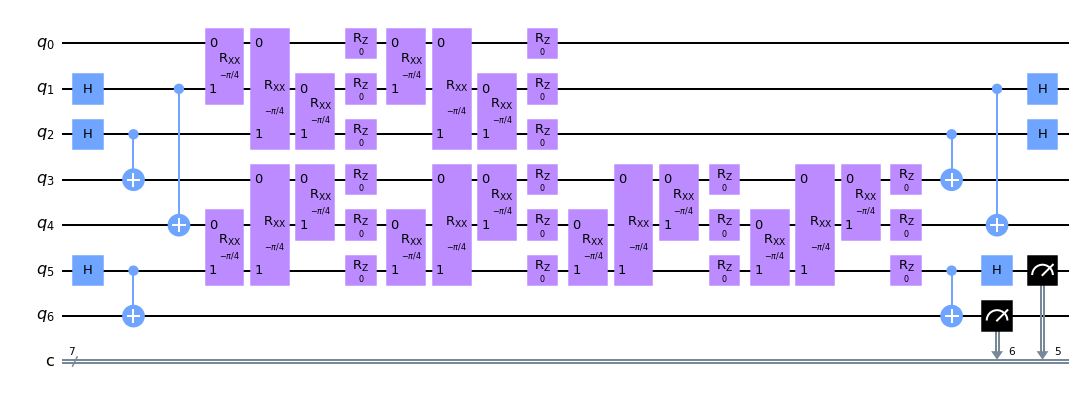

In [18]:
n = 7
circ = QuantumCircuit(n,n)

alpha = 0
print("Theta according to alpha={}:".format(alpha),get_theta_from_alpha(alpha))

bell_pairs = get_bell_pairs(circ)
entangle_bell_pairs(circ, bell_pairs)
circ.barrier()

apply_tunable_srambling(circ, alpha)

circ.barrier()
for pair in bell_pairs:
    disentangle_bell_pair(circ,pair)
circ.measure(5,5)
circ.measure(6,6)

# run on f_mel
pct = 100
shots = 100*pct
qobj = assemble(circ, shots=shots)
result = f_mel.run(qobj).result().get_counts()

bob_meas_1 = sum([v for (k,v) in result.items() if k[0]=="1"])
bob_meas_0 = sum([v for (k,v) in result.items() if k[0]=="0"])
q5_1 = sum([v for (k,v) in result.items() if k[1]=="1"])
q5_0 = sum([v for (k,v) in result.items() if k[1]=="0"])

print("\n Fidelity q5: \t{}%".format(q5_1/pct)) 
print("\n Fidelity q6: \t{}%".format(bob_meas_1/pct)) 

circ.draw('mpl', plot_barriers=False)

### alpha = 0.5

Theta according to alpha 0.5: 0.7853981633974483

 Fidelity q5: 	13.58%

 Fidelity q6: 	40.25%


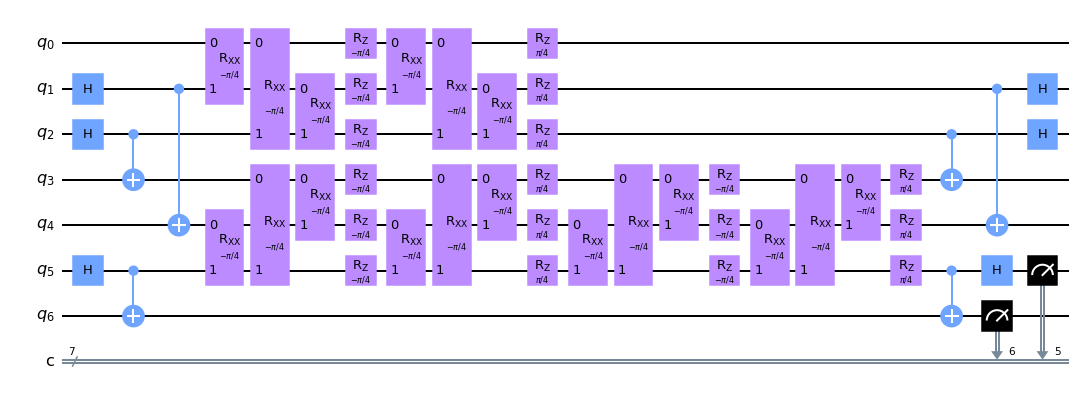

In [19]:
n = 7
circ = QuantumCircuit(n,n)

alpha = 0.5
print("Theta according to alpha {}:".format(alpha),get_theta_from_alpha(alpha))

bell_pairs = get_bell_pairs(circ)
entangle_bell_pairs(circ, bell_pairs)
circ.barrier()

apply_tunable_srambling(circ, alpha)

circ.barrier()
for pair in bell_pairs:
    disentangle_bell_pair(circ,pair)
circ.measure(5,5)
circ.measure(6,6)

# run on f_mel
pct = 100
shots = 100*pct
qobj = assemble(circ, shots=shots)
result = f_mel.run(qobj).result().get_counts()

bob_meas_1 = sum([v for (k,v) in result.items() if k[0]=="1"])
bob_meas_0 = sum([v for (k,v) in result.items() if k[0]=="0"])
q5_1 = sum([v for (k,v) in result.items() if k[1]=="1"])
q5_0 = sum([v for (k,v) in result.items() if k[1]=="0"])

print("\n Fidelity q5: \t{}%".format(q5_1/pct)) 
print("\n Fidelity q6: \t{}%".format(bob_meas_1/pct)) 

circ.draw('mpl', plot_barriers=False)

### alpha = 1

Theta according to alpha 1: 1.5707963267948966

 Fidelity q5: 	41.33%

 Fidelity q6: 	51.79%


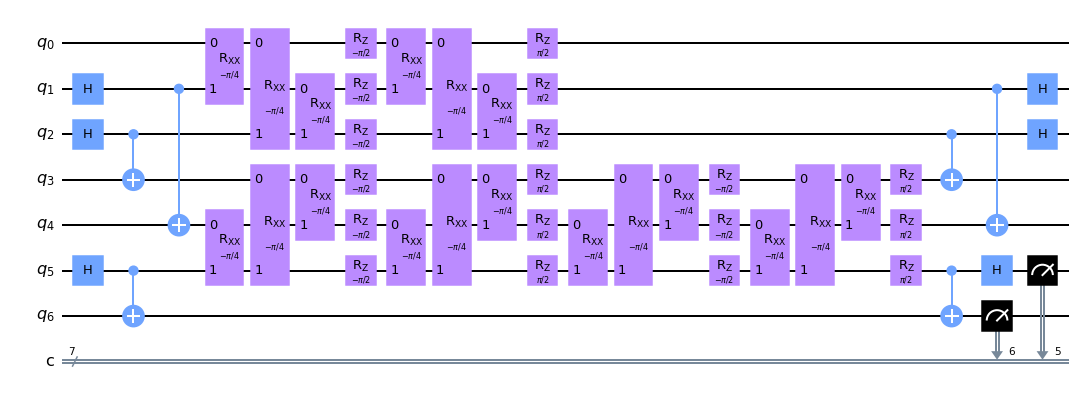

In [20]:
n = 7
circ = QuantumCircuit(n,n)

alpha = 1
print("Theta according to alpha {}:".format(alpha),get_theta_from_alpha(alpha))

bell_pairs = get_bell_pairs(circ)
entangle_bell_pairs(circ, bell_pairs)
circ.barrier()

apply_tunable_srambling(circ, alpha)

circ.barrier()
for pair in bell_pairs:
    disentangle_bell_pair(circ,pair)
circ.measure(5,5)
circ.measure(6,6)

# run on f_alma
pct = 100
shots = 100*pct
qobj = assemble(circ, shots=shots)
result = f_mel.run(qobj).result().get_counts()

bob_meas_1 = sum([v for (k,v) in result.items() if k[0]=="1"])
bob_meas_0 = sum([v for (k,v) in result.items() if k[0]=="0"])
q5_1 = sum([v for (k,v) in result.items() if k[1]=="1"])
q5_0 = sum([v for (k,v) in result.items() if k[1]=="0"])

print("\n Fidelity q5: \t{}%".format(q5_1/pct)) 
print("\n Fidelity q6: \t{}%".format(bob_meas_1/pct)) 

circ.draw('mpl', plot_barriers=False)